# Building the discriminator

The discriminator is a conventional CNN.

In [ ]:
import os

import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, GlobalAveragePooling2D, Dense, LeakyReLU, Dropout
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.models import Model

NUM_CLASSES = 10

# function for building the discriminator layers
def build_discriminator(start_filters, spatial_dim, filter_size):
    
    # function for building a CNN block for downsampling the image
    def add_discriminator_block(x, filters, filter_size, strides=2):
      x = Conv2D(filters, filter_size, padding='same')(x)
      x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      x = Conv2D(filters, filter_size, padding='same', strides=strides)(x)
      x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      return x
   
    # input is an image with shape spatial_dim x spatial_dim and 3 channels
    input = Input(shape=(spatial_dim, spatial_dim, 3))

    # design the discrimitor to downsample the image 4x (1/2^4)
    x = add_discriminator_block(input, start_filters * 4, filter_size) # 16x16
    x = add_discriminator_block(x, start_filters * 8, filter_size) # 8x8
    x = add_discriminator_block(x, start_filters * 16, filter_size) # 4x4
    
    
    # average and return a binary output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=input, outputs=x)

# Building the generator

The generator is a reverse CNN, so the flattening layers are changed by reshape layers and the convolutional layers are changed by transposed convolutional layers.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose, Reshape, ReLU

# start_filters = 32
def build_generator(start_filters, filter_size, latent_dim):
  
  # function for building a CNN block for upsampling the image
  def add_generator_block(x, filters, filter_size=4, strides=2):
      x = Conv2DTranspose(filters, filter_size, strides=strides, padding='same')(x)
      x = ReLU()(x)
      return x

  # input is a latent vector 
  input = Input(shape=(latent_dim,))

  # projection of the noise vector into a tensor with 
  # same shape as last conv layer in discriminator (d/8, d/8, 4*n_filters), d = 32
  x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(input)
  x = Reshape(target_shape=(4, 4, start_filters * 8))(x) # last conv layer shape

  # design the generator to upsample the image 4x
  x = add_generator_block(x, start_filters * 4, ) # 8x8
  x = add_generator_block(x, start_filters * 8, ) # 16x16 
  x = add_generator_block(x, start_filters * 16, ) # 32x32 
  x = add_generator_block(x, start_filters * 16, strides=1) # 32x32

  # turn the output into a 3D tensor, an image 32x32 with 3 channels 
  x = Conv2D(filters=3, kernel_size=3,  padding='same', activation='tanh')(x)
  
  return Model(inputs=input, outputs=x)

# Building the GAN

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# we will downscale the images
IMG_SIZE = 32 
# size of noise vector
LATENT_DIM_GAN = 100 
# filter size in conv layer
FILTER_SIZE = 5
# number of filters in conv layer
NET_CAPACITY = 16
# batch size
BATCH_SIZE = 64
# directory foverboser storing generated images
ROOT_DIR = 'visualization'
if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)
    
def construct_models(verbose=False):
    ### discriminator
    discriminator = build_discriminator(NET_CAPACITY, IMG_SIZE, filter_size=5)
    # compile discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['mae','accuracy'])

    ### generator
    # do not compile generator
    generator = build_generator(NET_CAPACITY, filter_size=5, latent_dim=LATENT_DIM_GAN)

    ### DCGAN is a trainable generator but
    # a untrainable discriminator
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False 
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['mae', 'accuracy'])

    if verbose: 
        generator.summary()
        discriminator.summary()
        gan.summary()
        
    return generator, discriminator, gan

# Preparing the dataset

In [ ]:
import numpy as np

# load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train, y_test))
# filtering only dog images

x_dogs_unorm = []
for i in range(x_all.shape[0]):
  if y_all[i] == 5:
    x_dogs_unorm.append(x_all[i])

x_dogs_unorm = np.array(x_dogs_unorm)

# airplane : 0
# automobile : 1
# bird : 2
# cat : 3
# deer : 4
# dog : 5
# frog : 6
# horse : 7
# ship : 8
# truck : 9

# scale from [0,255] to [-1,1]
x_dogs = 2 * (x_dogs_unorm/255) - 1

# Training the GAN

In [ ]:
# select a random set of real images for training the discriminator
# return a set of random real images labeled as 1 (real)
def generate_real_samples(dataset, n_samples):
  random_index = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[random_index]
  # train the discriminator on real images with label 1 and
  # random false labels
  Y = np.ones([BATCH_SIZE])
  return X, Y

def generate_fake_samples(gan, latent_dim, n_samples):
  # generate a set of random noise vectors
  noise = np.random.randn(n_samples, latent_dim)
  # generate a set of fake images using the generator
  X = gan.predict(noise, verbose=0)
  Y = np.zeros([BATCH_SIZE])
  return X, Y


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import clear_output
 
# number of discriminator updates per alternating training iteration
DISC_UPDATES = 1  
# number of generator updates per alternating training iteration
GEN_UPDATES = 1 
# interval for displaying generated images
PROGRESS_INTERVAL = 80

# function for training a GAN
def run_training(generator, discriminator, gan, start_it=0, num_epochs=1000):
  # list for storing loss
  avg_loss_discriminator = []
  avg_loss_generator = []
  avg_acc_generator = []
  avg_acc_discriminator = []
  total_it = start_it

  # main training loop
  for epoch in range(num_epochs):

      # alternating training loop
      loss_discriminator = []
      loss_generator = []
      for it in range(200): # 200 steps in each epoch

          #### Discriminator training loop ####
          for i in range(DISC_UPDATES): 
              # select a random set of real images
              imgs_real, _ = generate_real_samples(x_dogs, BATCH_SIZE)
              labels_real = np.random.uniform(0.7, 1, BATCH_SIZE)
              #labels_real = np.random.choice([0,1], BATCH_SIZE, p=[0.1, 0.9])

              # generate a set of fake images using the generator
              imgs_fake, labels_fake = generate_fake_samples(generator, LATENT_DIM_GAN, BATCH_SIZE)

              # train the discriminator on fake images with label 1
              d_loss_real = discriminator.train_on_batch(imgs_real, labels_real)[1]

              # train the discriminator on fake images with label 0
              d_loss_fake = discriminator.train_on_batch(imgs_fake, labels_fake)[1]

          #### Generator training loop ####
          loss = 0
          y = np.random.uniform(1, 0.7, BATCH_SIZE)
          # y = np.ones([BATCH_SIZE])
          for j in range(GEN_UPDATES):
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE, LATENT_DIM_GAN)
              # train the generator on fake images with label 1
              loss += gan.train_on_batch(noise, y)[1]

          # store loss
          loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
          loss_generator.append(loss / GEN_UPDATES)
          total_it += 1

          # display some fake images for visual control of convergence
          if total_it % PROGRESS_INTERVAL == 0:
              plt.figure(figsize=(5,2))
              num_vis = min(BATCH_SIZE, 5)
              imgs_real, _ = generate_real_samples(x_dogs, num_vis)

              imgs_fake, _ = generate_fake_samples(generator, LATENT_DIM_GAN, num_vis)

              for obj_plot in [imgs_fake, imgs_real]:
                  plt.figure(figsize=(num_vis * 3, 3))
                  for b in range(num_vis):
                      disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0), verbose=0)[0])
                      plt.subplot(1, num_vis, b + 1)
                      plt.title(str(round(disc_score, 3)))
                      plt.imshow(obj_plot[b] * 0.5 + 0.5) 
                  if obj_plot is imgs_fake:
                       plt.savefig(os.path.join(ROOT_DIR, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                  plt.show()  

      # visualize loss
      clear_output(True)
      print('Epoch', epoch)
      # select a random set of real images
      imgs_real, labels_real = generate_real_samples(x_dogs, BATCH_SIZE)
      # evaluate discriminator on real examples
      loss_real = discriminator.evaluate(imgs_real, labels_real, verbose=0)[0]
      # generate a random set of fake images
      imgs_fake, labels_fake = generate_fake_samples(generator, LATENT_DIM_GAN, BATCH_SIZE)
      # evaluate discriminator on fake examples
      loss_fake = discriminator.evaluate(imgs_fake, labels_fake, verbose=0)[0]

      avg_loss_discriminator.append(loss_real)
      avg_loss_generator.append(loss_fake)

      plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
      plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
      plt.legend(['real', 'fake'])
      plt.title('Discriminator loss')
      plt.show()

      # select a random set of real images
      imgs_real, labels_real = generate_real_samples(x_dogs, BATCH_SIZE)
      # evaluate discriminator on real examples
      acc_real = discriminator.evaluate(imgs_real, labels_real, verbose=0)[2]
      # generate a random set of fake images
      imgs_fake, labels_fake = generate_fake_samples(generator, LATENT_DIM_GAN, BATCH_SIZE)
      # evaluate discriminator on fake examples
      acc_fake = discriminator.evaluate(imgs_fake, labels_fake, verbose=0)[2]

      avg_acc_generator.append(acc_fake)
      avg_acc_discriminator.append(acc_real)

      plt.plot(range(len(avg_acc_discriminator)), avg_acc_discriminator)
      plt.plot(range(len(avg_acc_generator)), avg_acc_generator)
      plt.legend(['real', 'fake'])
      plt.title('Discriminator accuracy')
      plt.show()      

  return generator, discriminator, gan

In [ ]:
generator, discriminator, gan = construct_models(verbose=False)

Epoch 23


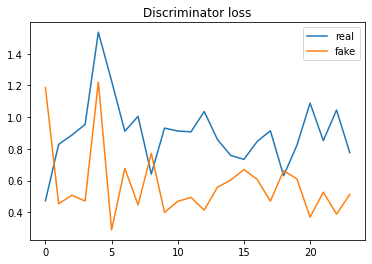

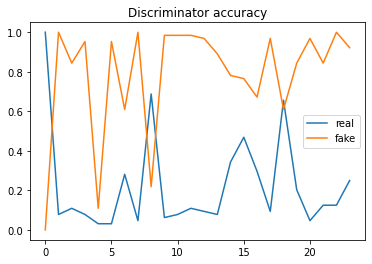

<Figure size 360x144 with 0 Axes>

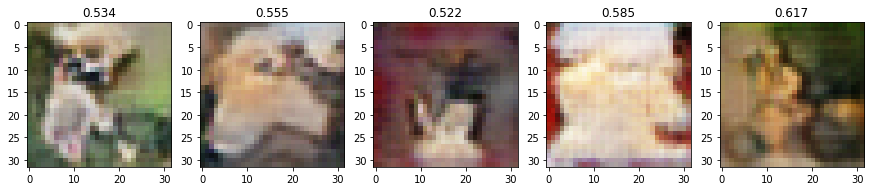

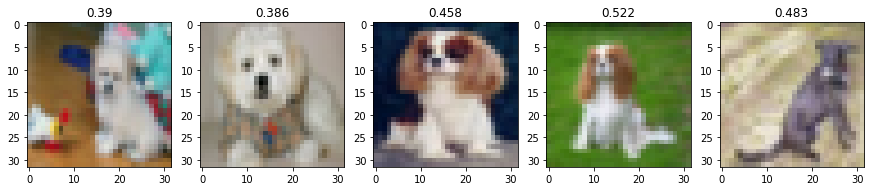

<Figure size 360x144 with 0 Axes>

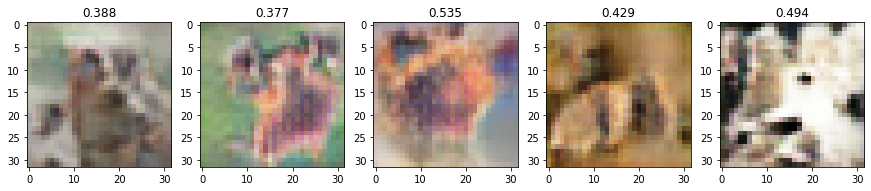

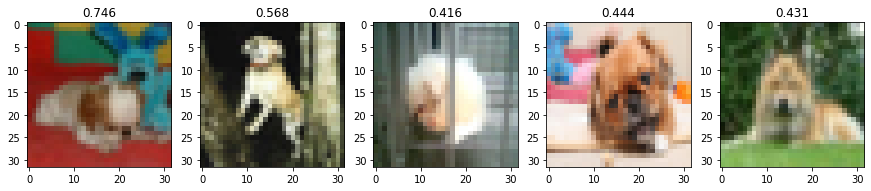

In [ ]:
generator, discriminator, gan = run_training(generator,
                                              discriminator,
                                              gan,
                                              num_epochs=500) 

In [ ]:
!zip -r ./file.zip ./visualization

In [ ]:
from google.colab import files
files.download("/content/file.zip")

In [ ]:
!mkdir -p ./saved_models
generator.save('./saved_models/my_model')
discriminator.save('./saved_models/my_model')
gan.save('./saved_models/my_model')

In [ ]:
!zip -r ./models.zip ./saved_models

In [ ]:
from google.colab import files
files.download("/content/models.zip")

In [ ]:
num_vis = 5
imgs_fake, _ = generate_fake_samples(generator, LATENT_DIM_GAN, num_vis)
      
plt.figure(figsize=(num_vis * 3, 3))
for b in range(5):
  disc_score = float(discriminator.predict(np.expand_dims(imgs_fake[b], axis=0), verbose=0))
  plt.subplot(1, num_vis, b + 1)
  plt.title(str(round(disc_score, 3)))
  plt.imshow(imgs_fake[b] * 0.5 + 0.5) 

# if obj_plot is imgs_fake:
#   plt.savefig(os.path.join(ROOT_DIR, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
# plt.show()  